# Fire or Not?  
<hr style="border:2px solid magenta"> 

**Description** 
* Wildfires are very unpredictable and can occur randomly. Using sattelite images, we can in real time detect a wildfire and warn the proper authorities to mitigate the outgoing damage from wildfires. 

**Objective**
* Create a model that can detect if there is a wildfire in the image with a high f1 score as this is a measure that combines recall and precision of the model. We would want authorities to respond to a real wildfire and false alarm rather than not be alerted that there is a wildfire. It is better to be safe than sorry.  

**Methodology**
* Using a Convolutional Neural Network for wildfire detection. The architecture was designed usign Keras API and was implemented using Python, Tensorflow.  

**Data**
* The dataset was provided by Kaggle: [Wildfire Prediction Dataset (Satellite Images)](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data). It has been divided into three directories: test, train, and validation. The file name are the coordinates of the wildfire location.

### Imports
<hr style="border:2px solid magenta">  

Grabbing the important imports needed

In [26]:
import tensorflow as tf
import datetime

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend

from sklearn.metrics import classification_report
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives

In [27]:
from src.extract_to_df import extract_to_df
from src.visualizations import plot_graph
from src.metric_notes import metric_note

In [28]:
#prevent a bug that some images are truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


### Extracting Data  
<hr style="border:2px solid magenta">  

Setting the paths to the data

In [29]:
test = Path('Data/test')
train = Path('Data/train')
valid = Path('Data/valid')

Using a function called extract_to_df that is in the src folder. This function will extract useful information from each file and return a dataframe containing the relative path, latitude and longtitude coordinates, and the class of the image : wildfire or nowildfire. 

In [30]:
train_df = extract_to_df(train, 'Train')
test_df = extract_to_df(test, 'Test')
val_df = extract_to_df(valid,'Valid')

Creating a function to make the path to tensorboard log info for each model.

In [31]:
def create_log_path(name):
    log_dir = "logs/fit/" + f'{name}/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return log_dir

Creating the generators used to extract the images. Using data augmentation to combat some overfitting seen in our previous model. 

In [32]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    horizontal_flip = True, 
    vertical_flip = True
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

Extracting images. Starting with 32x32 pixels. Might change it to 64x64 or 224x224 which is another image size standard. Pixel can be changed for the images. It helps with renaming the files and such later on. 

In [33]:
pixel = 64
size = f'{pixel}x{pixel}'

Grabbing the images.

In [34]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size = (pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 128)

valid_images = train_generator.flow_from_dataframe(dataframe=val_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size=(pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 64)

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Path',
                                                 y_col='Label',
                                                 target_size=(pixel,pixel),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size=128)


Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


There is a lot of images already. Roughly 42850 images.

In [35]:
metrics = metric_note(train_images, test_images, valid_images)

### Modeling TIME  
<hr style="border:2px solid magenta">  

Let's do a simple CNN with 1-Convolutional Layer

In [36]:
cnn1 = Sequential()
cnn1.add(Conv2D(filters=32,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(pixel,pixel, 3)))
cnn1.add(MaxPooling2D(pool_size=(2,2)))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(1, activation='sigmoid'))

cnn1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', TruePositives(thresholds= .5), TrueNegatives(thresholds= .5), FalsePositives(thresholds= .5), FalseNegatives(thresholds= .5)])


Adding an early stopping to prevent overfitting and save computational resources and time. Also adding a tensorboard callback to analyze the performance closely. 

In [37]:
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )

tensor = tf.keras.callbacks.TensorBoard(log_dir=create_log_path('CNN1'), histogram_freq=1)

Fit the train_images into this one deep cnn with a batch size of 64, epochs of 50, validation data with valid_iamges. Using the early stopping for the reason mentioned above and using workers of 6 (Which I believe is similar to n_jobs in sklearn)

In [38]:
results1 = cnn1.fit(train_images,
                    batch_size = 64, 
                    epochs = 1000,
                    validation_data = valid_images,
                    callbacks = [early_stop, tensor],
                    workers = 10)

Epoch 1/1000
237/237 [==============================] - 67s 266ms/step - loss: 0.3172 - accuracy: 0.8709 - true_positives: 14027.0000 - true_negatives: 12318.0000 - false_positives: 2182.0000 - false_negatives: 1723.0000 - val_loss: 0.2098 - val_accuracy: 0.9203 - val_true_positives: 3218.0000 - val_true_negatives: 2580.0000 - val_false_positives: 240.0000 - val_false_negatives: 262.0000
Epoch 2/1000
237/237 [==============================] - 22s 89ms/step - loss: 0.2155 - accuracy: 0.9117 - true_positives: 14797.0000 - true_negatives: 12782.0000 - false_positives: 1718.0000 - false_negatives: 953.0000 - val_loss: 0.1826 - val_accuracy: 0.9297 - val_true_positives: 3260.0000 - val_true_negatives: 2597.0000 - val_false_positives: 223.0000 - val_false_negatives: 220.0000
Epoch 3/1000
237/237 [==============================] - 23s 94ms/step - loss: 0.1928 - accuracy: 0.9255 - true_positives: 14925.0000 - true_negatives: 13072.0000 - false_positives: 1428.0000 - false_negatives: 825.0000 -

Already at 95% accurate and 0.1220 log loss. This is a strong model already.

99/99 [==============================] - 14s 144ms/step - loss: 0.1057 - accuracy: 0.9614 - true_positives: 3369.0000 - true_negatives: 2688.0000 - false_positives: 132.0000 - false_negatives: 111.0000


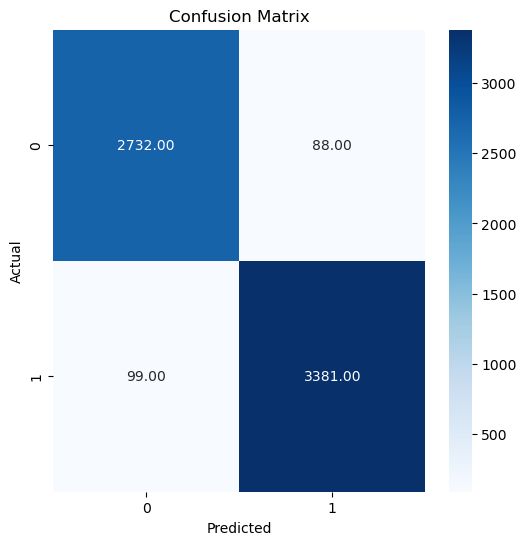

In [39]:
metrics.evaluate(cnn1, 'CNN 1', size)

In [40]:
metrics.printout

,Model,Size,train log_loss,train accuracy,train TP,train TN,train FP,train FN,test log_loss,test accuracy,test TP,test TN,test FP,test FN,val log_loss,val accuracy,val TP,val TN,val FP,val FN
0,CNN 1,64x64,0.103989,0.96,15365.0,13675.0,825.0,385.0,0.081797,0.970317,3381.0,2732.0,88.0,99.0,0.105729,0.961429,3369.0,2688.0,132.0,111.0


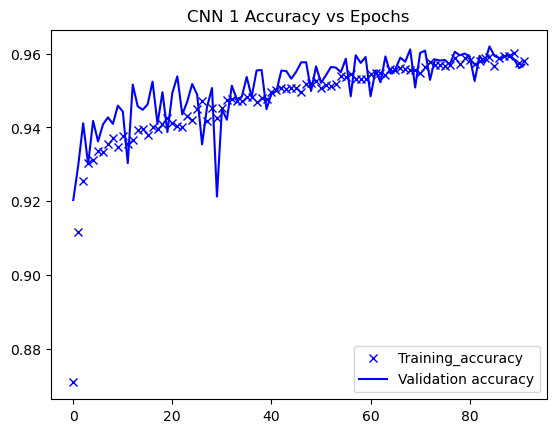

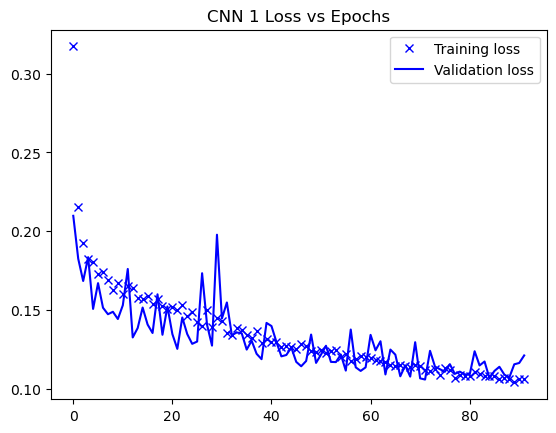

<Figure size 640x480 with 0 Axes>

In [41]:
plot_graph(results1, size, 'CNN 1')

In [42]:
backend.clear_session()


<hr style="border:2px solid magenta">  

Let's increase the complexity by making 4 deep. I am going to add some dropout and batchnormalization to help prevent overfitting. 

In [43]:
cnn4 = Sequential()

cnn4.add(Conv2D(filters=32,
                kernel_size=3,
                activation='relu',
                input_shape=(pixel,pixel, 3)))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=32,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=64,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=128,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Flatten())

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Dense(1, activation='sigmoid'))

cnn4.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', TruePositives(thresholds= .5), TrueNegatives(thresholds= .5), FalsePositives(thresholds= .5), FalseNegatives(thresholds= .5)])


In [44]:
tensor = tf.keras.callbacks.TensorBoard(log_dir=create_log_path('CNN4'), histogram_freq=1)

In [45]:
results4 = cnn4.fit(train_images,
                    batch_size = 64, 
                    epochs = 1000,
                    validation_data = valid_images,
                    callbacks = [early_stop, tensor],
                    workers = 10)

Epoch 1/1000
237/237 [==============================] - 28s 109ms/step - loss: 0.2372 - accuracy: 0.9078 - true_positives: 14552.0000 - true_negatives: 12908.0000 - false_positives: 1592.0000 - false_negatives: 1198.0000 - val_loss: 0.6688 - val_accuracy: 0.5559 - val_true_positives: 3480.0000 - val_true_negatives: 22.0000 - val_false_positives: 2798.0000 - val_false_negatives: 0.0000e+00
Epoch 2/1000
237/237 [==============================] - 21s 86ms/step - loss: 0.1902 - accuracy: 0.9255 - true_positives: 14777.0000 - true_negatives: 13219.0000 - false_positives: 1281.0000 - false_negatives: 973.0000 - val_loss: 0.2646 - val_accuracy: 0.8933 - val_true_positives: 3440.0000 - val_true_negatives: 2188.0000 - val_false_positives: 632.0000 - val_false_negatives: 40.0000
Epoch 3/1000
237/237 [==============================] - 21s 87ms/step - loss: 0.1696 - accuracy: 0.9341 - true_positives: 14901.0000 - true_negatives: 13357.0000 - false_positives: 1143.0000 - false_negatives: 849.0000 -

This took around 15-20 mins due to early stopping. 

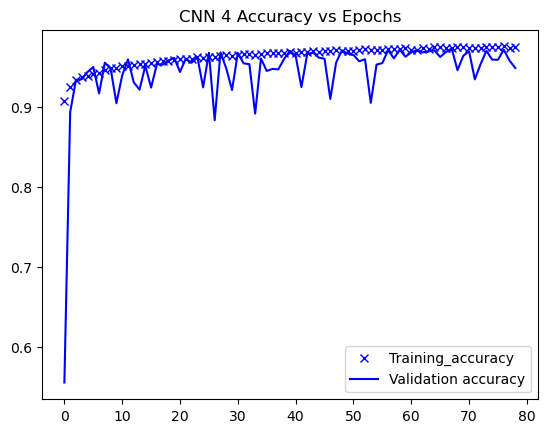

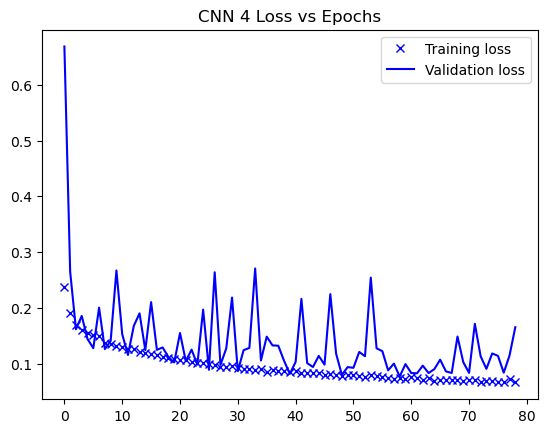

<Figure size 640x480 with 0 Axes>

In [46]:
plot_graph(results4, size, 'CNN 4')

The validation loss is very volatile. The model coulda learned longer but the early stopping prevented it. I played around with the early stopping. and this was the version that did it the longest without worsening. 

99/99 [==============================] - 12s 122ms/step - loss: 0.0818 - accuracy: 0.9689 - true_positives: 3344.0000 - true_negatives: 2760.0000 - false_positives: 60.0000 - false_negatives: 136.0000


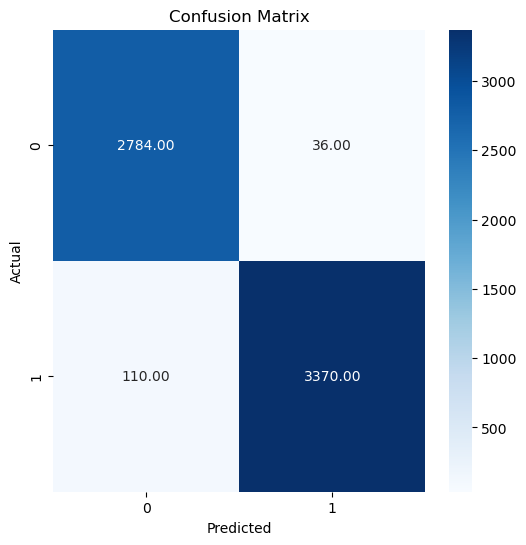

In [47]:
metrics.evaluate(cnn4, 'CNN 4', size)


In [48]:
metrics.printout

,Model,Size,train log_loss,train accuracy,train TP,train TN,train FP,train FN,test log_loss,test accuracy,test TP,test TN,test FP,test FN,val log_loss,val accuracy,val TP,val TN,val FP,val FN
0,CNN 1,64x64,0.103989,0.960000,15365.0,13675.0,825.0,385.0,0.081797,0.970317,3381.0,2732.0,88.0,99.0,0.105729,0.961429,3369.0,2688.0,132.0,111.0
1,CNN 4,64x64,0.069626,0.973818,15304.0,14154.0,346.0,446.0,0.062756,0.976825,3370.0,2784.0,36.0,110.0,0.081780,0.968889,3344.0,2760.0,60.0,136.0


In [49]:
backend.clear_session()

<hr style="border:2px solid magenta">  

Saving the printout as a csv to keep.

In [50]:
metrics.printout.to_csv(f'Dataframes/{size}CNN.csv')